# Telco Customer Churn Analysis: Predicting Churn with Supervised Machine Learning Models


**Data Source:** [Telco Customer Churn Dataset](https://github.com/IBM/telco-customer-churn-on-icp4d/tree/master/data)  

---

## Project Topic

This project focuses on predicting customer churn for a fake telecom company named Telco using supervised machine learning. This classification problem is a type of supervised learning where the goal is to predict a binary outcome of whether a customer will churn (leave) or not (stay). By identifying customers likely to churn (leave), businesses can proactively work on improving retention strategies. This makes this problem highly relevant to industries with subscription based services.


## Project Goal

The goal of this project is to build a reliable machine learning model to predict customer churn based on customer attributes. The importance of this project lies in its potential to reduce customer turnover, which negatively impacts a company's revenue. Additionally, this project aims to enhance my skills in data preprocessing, model evaluation, and interpretation, especially for imbalanced datasets.


## Data Section

### Data Source

The data used in this project is sourced from the [Telco Customer Churn Dataset](https://github.com/IBM/telco-customer-churn-on-icp4d/tree/master/data). It is a publicly available dataset provided by **IBM** to demonstrate churn analysis with machine learning.

### Data Description

The dataset contains 21 features and 7,043 rows of customer data (excluding the first row of headers), with a total size of  **948 KB**. Each row represents a customer, and the columns represent attributes about the customer and their usage of Telco's services. Below is a summary of the data:


- **Number of rows (samples):** 7,043  
- **Number of columns (features):** 21  
- **Data Size:** ~948 KB  

**Key Features:**
- **Categorical Features:** `gender`, `SeniorCitizen`, `Partner`, `Dependents`, `PhoneService`, `MultipleLines`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `Contract`, `PaperlessBilling`, `PaymentMethod`, `Churn`  
- **Numerical Features:** `tenure`, `MonthlyCharges`, `TotalCharges`  

**Context:**  
This data is based on IBM's fictional Telco company in California that provides phone and internet services to 7,043 customers during Q3. The data tracks customer churn based on various features including demographics, service usage, and subscription details. The `Churn` column indicates whether the customer departed within the last month. A `Churn=Yes` means that the customer left, whereas a `Churn=No` means a customer stayed.

**Data Attributes:**
- Total rows (including header row): **7044**  
- Total columns: **21**  
- Examples of column names: `customerID`, `gender`, `tenure`, `InternetService`, `PaymentMethod`, `MonthlyCharges`, `Churn`.  

The dataset is tabular and includes both categorical and numerical features, making it a good candidate for machine learning classification models.




##  Necessary Libraries 



In [8]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from imblearn.combine import SMOTEENN
%matplotlib inline

## Loading the Data and Visualizing

In [9]:
# lets keep an original dataframe for EDA
df_og = pd.read_csv("Telco-Customer-Churn.csv")
# main df for cleaning and FE
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Displaying Data Information

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 



## Displaying Unique Values in Columns
We can see above that `TotalCharges` is an object data type, so we will need to explore why since we expect it to be numeric. We will likely need to convert this to numeric for more efficient handling in our models.



In [11]:
# check what unique values exist in each column to confirm number of distinct categories 
for c in df.columns[1:]: # use 1 becasue customerIDs are all unique
    print(c, df[c].unique())

gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges ['29.85' '1889

##  Data Cleaning
### Explanation of Data Cleaning Steps:



**Handling Missing Values:**

After the pd.to_numeric() function was used to covert the values in 'TotalCharges' to numeric, any invalid string entries (ex: '') are coerced to NaN.The `TotalCharges` column contained 11 missing (NaN) values. These rows were dropped because they only represent a small portion of the data.

**Scaling Numerical Features:**

Columns with numerical features like `tenure`, `MonthlyCharges`, and `TotalCharges` were scaled with StandardScaler() to transform the features to have a mean of 0 and standard deviation of 1. Now numerical features all have similar importance. 

**Standardizing Binary Features:**  

Columns like `MultipleLines`, `OnlineSecurity`, and others had inconsistent values such as `No phone service` or `No internet service`. These were converted to a single `No` to simplify the binary encoding.


**Encoding Categorical Variables:**

Binary categorical columns were converted to numeric format (1 for Yes, 0 for No) to make them readable to the models. Multi-category columns like `gender`, `InternetService`, and `PaymentMethod` were one-hot encoded to allow the models to process these features.


**Column Name Cleanup:**

Spaces and special characters in the column names were removed for better compatibility with the models.


**Dropping Unnecessary Features:**

The `customerID` column was dropped because it is a unique identifier with no predictive power to this problem.


**Final Checks:**

Ensured no missing values or non-numeric data types were in the cleaned dataset.



In [12]:
# convert TotalCharges to numeric and drop rows with NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"Rows with NaN in TotalCharges: {df['TotalCharges'].isna().sum()}") # check NaN count
df = df.dropna(subset=['TotalCharges']) 
print(f"Rows left after TotalCharges cleanup: {len(df)}")

# numerical features to z-scale
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
# fit the scaler to the numerical features
scaler.fit(df[numerical_features])
# transform the features
df[numerical_features] = scaler.transform(df[numerical_features])

# convert 'No phone service' and 'No internet service' to 'No' for consistency and simple binary encoding
columns_with_two_nos = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# replace columns_with_two_nos to No 
for col in columns_with_two_nos:
    df[col] = df[col].replace({'No phone service': 'No', 'No internet service': 'No'})

# encode binary categorical columns
binary_columns = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
df[binary_columns] = df[binary_columns].replace({'Yes': 1, 'No': 0})

# onehot encode multi-category columns
df = pd.get_dummies(df, columns=['gender', 'InternetService', 'Contract', 'PaymentMethod'], drop_first=True)
# clean column names to remove spaces and special characters because after pd.get_dummies(), some still have extra spacing 
df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
print("Columns after cleaning:", df.columns)
print(df.info()) # make sure all features are numeric

# drop unnecessary features 
df = df.drop(['customerID'], axis=1) # axis 1 specifies to drop columns

# to make sure we dropped all NaN values
print("verify no remaining NaN values: ", df.isna().sum()) 
print(f"Rows with NaN: {df.isna().sum()}") # check NaN count
print(f"Rows left after cleanup: {len(df)}")

# check data types and make sure all features are numeric now
print("Columns with non-numeric data:", df.select_dtypes(include='object').columns) # will return empty list if so 

# display dataset info and first few rows
print("Confirm all columns are numeric and non-null", df.info())  
print("Preview the first 5 rows", df.head())

Rows with NaN in TotalCharges: 11
Rows left after TotalCharges cleanup: 7032
Columns after cleaning: Index(['customerID', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Male', 'InternetService_Fiber_optic', 'InternetService_No',
       'Contract_One_year', 'Contract_Two_year',
       'PaymentMethod_Credit_card_automatic', 'PaymentMethod_Electronic_check',
       'PaymentMethod_Mailed_check'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customerID                           7032 non-null   object 
 1   SeniorCitizen                        

## Exploratory Data Analysis (EDA)

This section involves an exploration of the data to find patterns, relationships, and distributions of features. It includes visualizations as well as analysis to identify potential trends/relationships that could inform the modeling process. Here's what was done:

### Count Plots for Churn Distribution:

Count plots were made to show the overall distribution of churn and its breakdown across gender and payment methods. Subplots provided a clear view of churn trends for different payment methods.

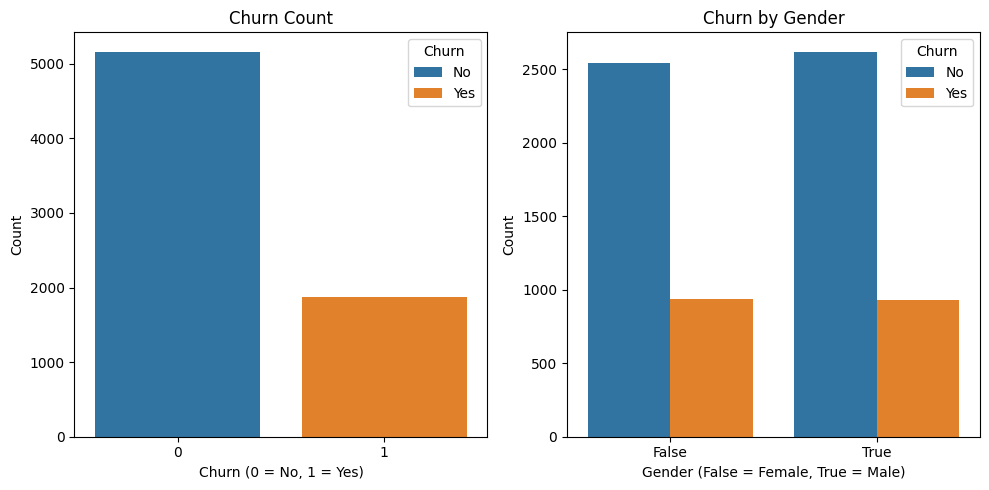

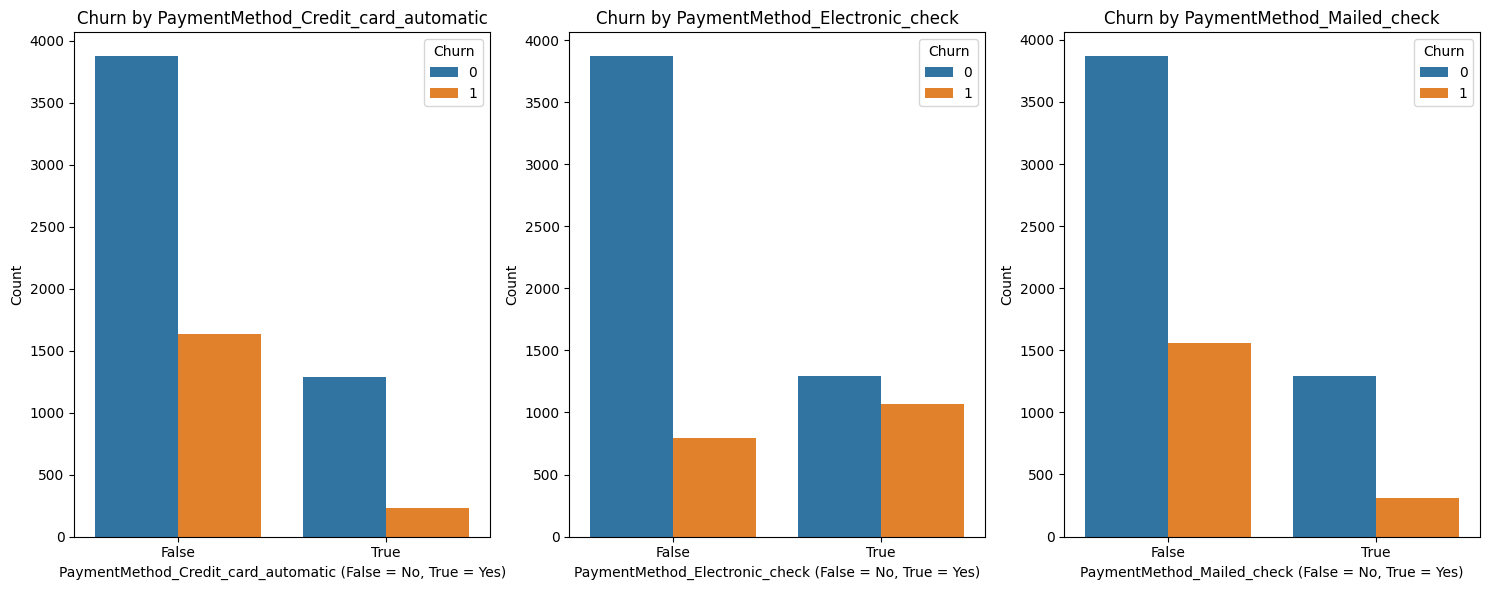

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 
# churn count plot
sns.countplot(x='Churn', hue='Churn', data=df, ax=axes[0]) 
axes[0].set_title('Churn Count')
axes[0].set_xlabel('Churn (0 = No, 1 = Yes)')
axes[0].set_ylabel('Count')
axes[0].legend(title='Churn', labels=['No', 'Yes']) 

# churn vs gender
sns.countplot(x='gender_Male', hue='Churn', data=df, ax=axes[1])  
axes[1].set_title('Churn by Gender')
axes[1].set_xlabel('Gender (False = Female, True = Male)')
axes[1].set_ylabel('Count')
axes[1].legend(title='Churn', labels=['No', 'Yes'])  
plt.tight_layout()
plt.show()

payment_method_labels = ['PaymentMethod_Credit_card_automatic', 'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check']
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes = axes.flatten() # flatten the axes array for easier indexing

for i, (payment_method, label) in enumerate(zip(payment_method_labels, payment_method_labels)):
        sns.countplot(x=payment_method, hue='Churn', data=df, ax=axes[i])
        axes[i].set_title(f'Churn by {label}')
        axes[i].set_xlabel(f'{label} (False = No, True = Yes)')
        axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Feature Relationships:

Histograms were plotted to explore the distributions of `tenure`, `MonthlyCharges`, and  `TotalCharges`. These visualizations help identify skewness, multimodality, and uniformity in the data. Also, scatter plots were used to look for relationships between the features and the target (Churn). This allowed me to visualize how `MonthlyCharges`, `tenure`, and `TotalCharges` differ for churned vs. non-churned customers.



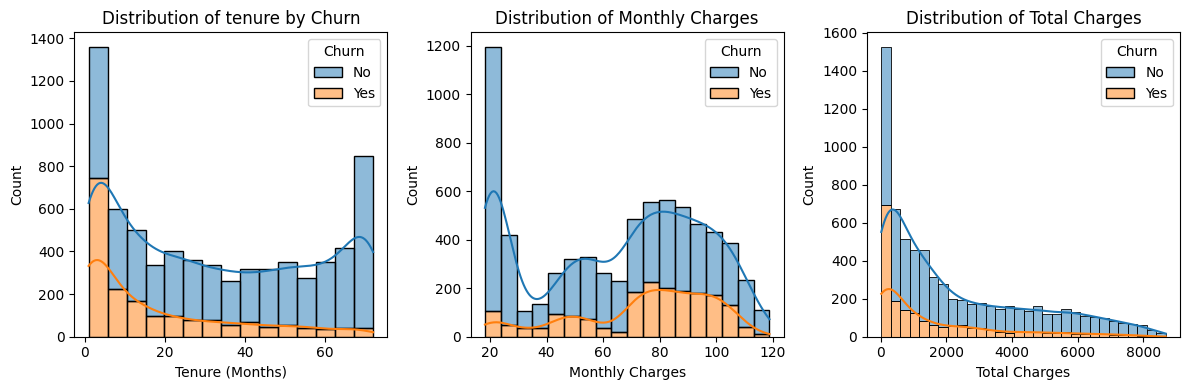

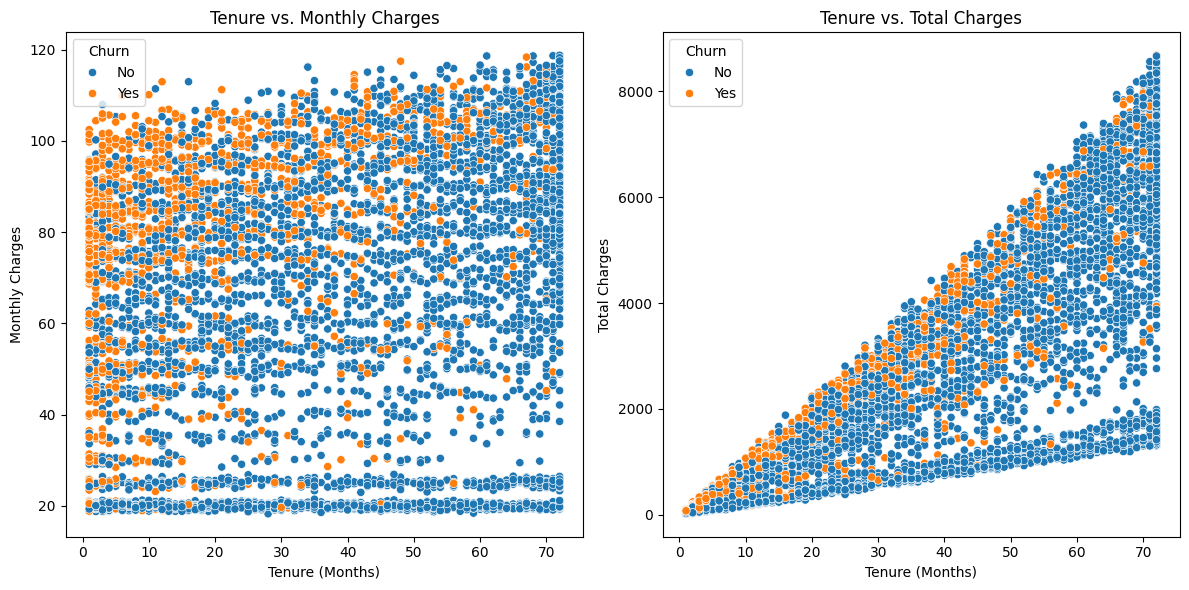

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 
sns.histplot(data=df_og, x='tenure', hue='Churn', kde=True, multiple='stack', ax=axes[0])
axes[0].set_title('Distribution of tenure by Churn')
axes[0].set_xlabel('Tenure (Months)')
axes[0].set_ylabel('Count')

sns.histplot(data=df_og, x='MonthlyCharges', hue='Churn', kde=True, multiple='stack', ax=axes[1])
axes[1].set_title('Distribution of Monthly Charges')
axes[1].set_xlabel('Monthly Charges')
axes[1].set_ylabel('Count')

df_og['TotalCharges'] = pd.to_numeric(df_og['TotalCharges'], errors='coerce')
df_og = df_og.dropna(subset=['TotalCharges']) 
sns.histplot(data=df_og, x='TotalCharges', hue='Churn', kde=True, multiple='stack', ax=axes[2], bins=30)
axes[2].set_title('Distribution of Total Charges')
axes[2].set_xlabel('Total Charges')
axes[2].set_ylabel('Count')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  
# relationship between tenure and MonthlyCharges
sns.scatterplot(data=df_og, x='tenure', y='MonthlyCharges', hue='Churn', ax=axes[0])
axes[0].set_title('Tenure vs. Monthly Charges')
axes[0].set_xlabel('Tenure (Months)')
axes[0].set_ylabel('Monthly Charges')

# relationship between tenure and TotalCharges
sns.scatterplot(data=df_og, x='tenure', y='TotalCharges', hue='Churn', ax=axes[1])
axes[1].set_title('Tenure vs. Total Charges')
axes[1].set_xlabel('Tenure (Months)')
axes[1].set_ylabel('Total Charges')
plt.tight_layout()
plt.show()

#### Boxplots for Churn Analysis:
Boxplots of `MonthlyCharges` `TotalCharges` and `tenure` were made to see how these features differ between customers who churned (Churn = 1) and those who did not (Churn = 0).


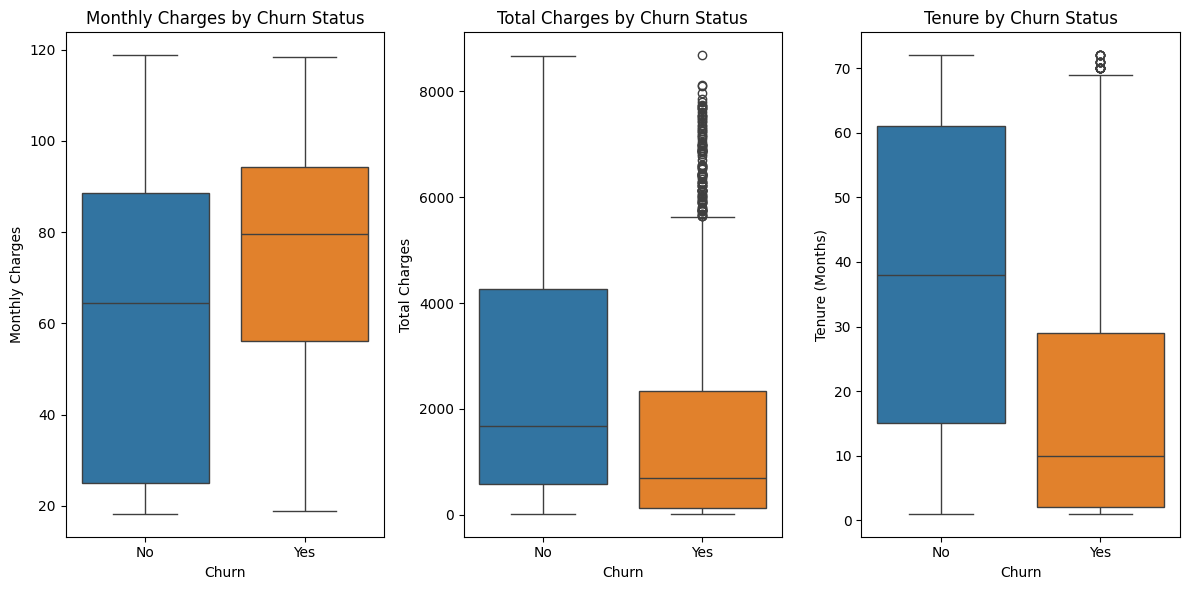

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))  
sns.boxplot(x='Churn', y='MonthlyCharges', hue='Churn', data=df_og, ax=axes[0])
axes[0].set_title('Monthly Charges by Churn Status')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Monthly Charges')

sns.boxplot(x='Churn', y='TotalCharges', hue='Churn', data=df_og, ax=axes[1] )
axes[1].set_title('Total Charges by Churn Status')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Total Charges')

sns.boxplot(x='Churn', y='tenure', hue='Churn', data=df_og, ax=axes[2])
axes[2].set_title('Tenure by Churn Status')
axes[2].set_xlabel('Churn')
axes[2].set_ylabel('Tenure (Months)')
plt.tight_layout()
plt.show()

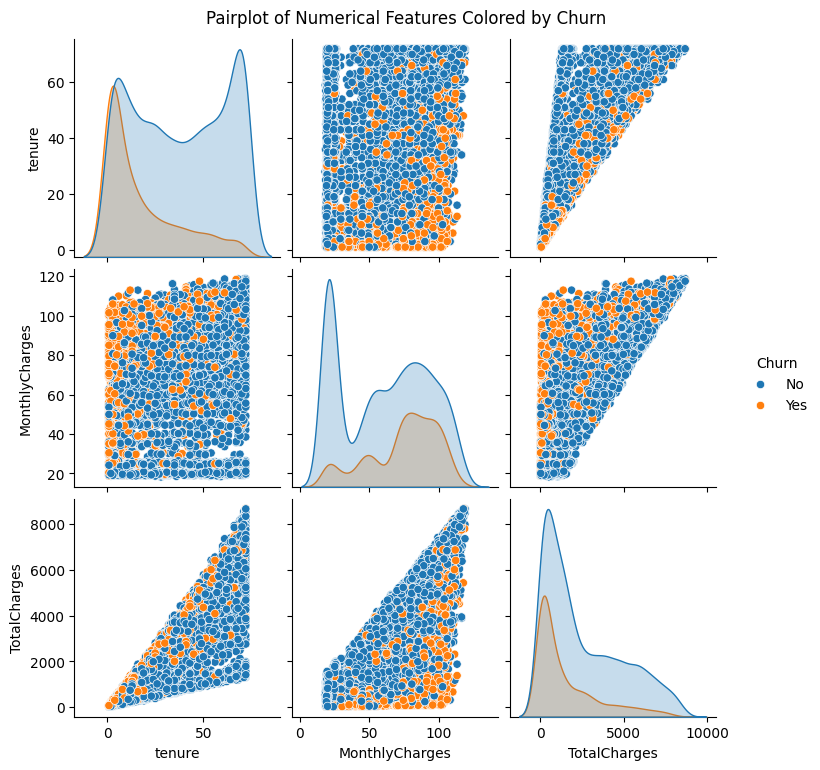

In [35]:
sns.pairplot(df_og[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], hue='Churn')
plt.suptitle('Pairplot of Numerical Features Colored by Churn', y=1.02) 
plt.show()


### Correlation Analysis:

The correlation matrix and its heatmap showed the relationships among all features to identify highly correlated pairs and potential multicollinearity issues.

In [36]:
correlation_matrix = df.corr()
print(correlation_matrix)

                                     SeniorCitizen   Partner  Dependents  \
SeniorCitizen                             1.000000  0.016957   -0.210550   
Partner                                   0.016957  1.000000    0.452269   
Dependents                               -0.210550  0.452269    1.000000   
tenure                                    0.015683  0.381912    0.163386   
PhoneService                              0.008392  0.018397   -0.001078   
MultipleLines                             0.142996  0.142561   -0.024307   
OnlineSecurity                           -0.038576  0.143346    0.080786   
OnlineBackup                              0.066663  0.141849    0.023639   
DeviceProtection                          0.059514  0.153556    0.013900   
TechSupport                              -0.060577  0.120206    0.063053   
StreamingTV                               0.105445  0.124483   -0.016499   
StreamingMovies                           0.119842  0.118108   -0.038375   
PaperlessBil

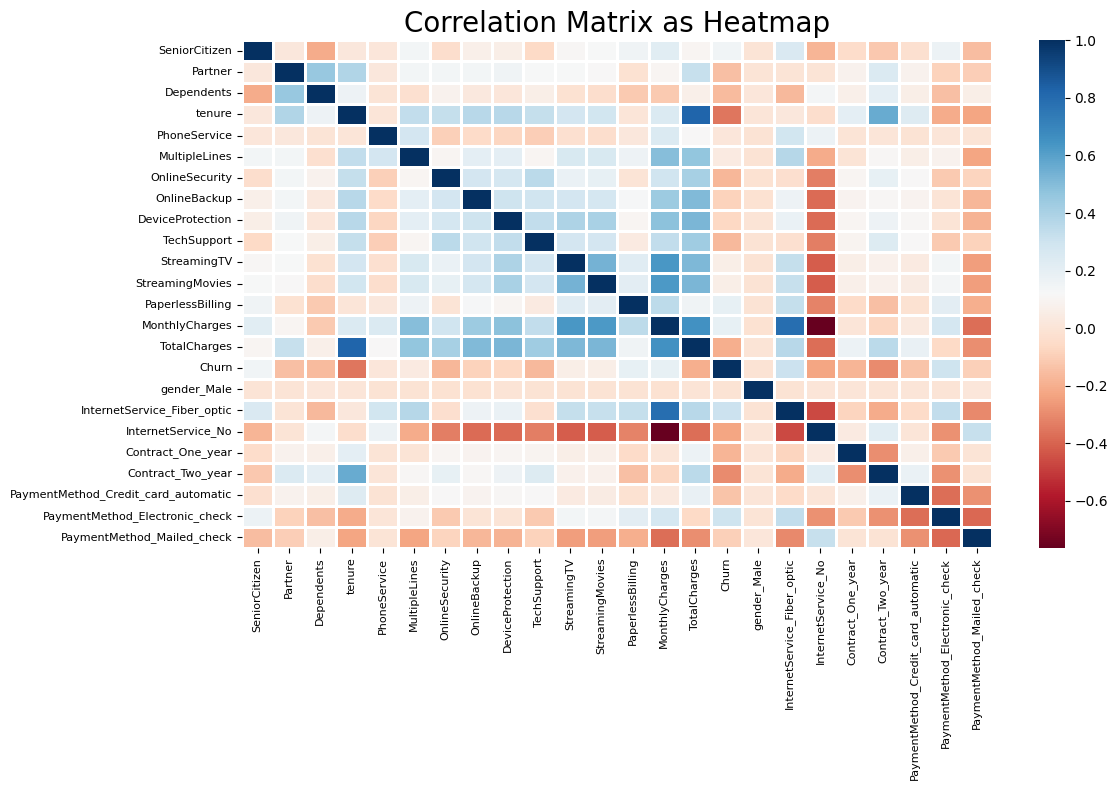

In [37]:
# plot correlation matrix as heatmap
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=False, cmap="RdBu", linewidths=1.0, annot_kws={"size": 10},)
plt.title("Correlation Matrix as Heatmap", fontsize=20)
plt.xticks(rotation = 90, fontsize = 8) # rotate x-axis labels to fit 
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [38]:
# use VIF to find multicollinearity with features
bool_columns = df.select_dtypes(include='bool').columns
# convert only boolean cols to int for VIF
df[bool_columns] = df[bool_columns].astype(int)
vif_data = pd.DataFrame()
vif_data['Feature'] = df.columns
vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
print(vif_data)

# convert bool cols back to og type
df[bool_columns] = df[bool_columns].astype(bool)

                                Feature        VIF
0                         SeniorCitizen   1.378602
1                               Partner   2.827074
2                            Dependents   1.970066
3                                tenure   7.600473
4                          PhoneService  10.336816
5                         MultipleLines   2.659099
6                        OnlineSecurity   1.934223
7                          OnlineBackup   2.093503
8                      DeviceProtection   2.268536
9                           TechSupport   2.089474
10                          StreamingTV   3.083795
11                      StreamingMovies   3.061661
12                     PaperlessBilling   2.973890
13                       MonthlyCharges  17.454487
14                         TotalCharges  10.882022
15                                Churn   1.902151
16                          gender_Male   2.020103
17          InternetService_Fiber_optic   7.926785
18                   InternetSe

In [39]:
# TotalCharges had high VIF so combining into new feature
df['RevenuePerMonth'] = df['TotalCharges'] / df['tenure']
df = df.drop(columns=['TotalCharges'])
# PhoneService also high VIF so drop
df = df.drop(columns=['PhoneService'])

### EDA Key Findings:

1. High churn rates are correlated to shorter tenures and higher monthly charges.
2. Payment methods like electronic checks may predict churn more effectively than others.
3. Correlation analysis shows key features like tenure and MonthlyCharges are important for predictive modeling.
4. PhoneService and TotalCharges had very high VIF around 10 so PhoneServce was dropped and TotalCharges was feature engineered.

Possible Challenges:

- Features like tenure and TotalCharges could introduce multicollinearity in linear models. That is why I removed them.
- The highly imbalanced churn distribution could impact model performance and may require resampling techniques.


## Models

This section explores a range of models (linear and non-linear) appropriate for the classification problem of predicting customer churn. The models were chosen to handle various complexities in the data, like feature interactions and data imbalance. Each model's fit was evaluated based on its ability to deal with feature collinearity and overfitting while providing useful insights into feature importance.

## Linear Models 

1. **Linear Models:**
   - Ordinary Least Squares (OLS) and Logistic Regression were implemented to provide a baseline for comparison. These models are interpretable but struggle with non-linear relationships.




In [40]:
X = df.drop('Churn', axis=1) 
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Finding the top 5 predictors:


In [41]:
X_train_with_target = X_train.copy() # combine X_train/y_train 
X_train_with_target['Churn'] = y_train # add Churn to X_train

# list of possible predictors to test (exclude 'Churn')
predictors = []
for column in X_train.columns:
    if column != 'Churn': 
        predictors.append(column)

adjusted_R2_values = {}
# calculate adjusted R^2 for each predictor
for predictor in predictors:
    model = smf.ols(formula=f'Churn ~ {predictor}', data=X_train_with_target).fit()
    adjusted_R2_values[predictor] = model.rsquared_adj

dataframe_of_adjusted_R2 = pd.DataFrame.from_dict(adjusted_R2_values, orient='index', columns=['AdjustedR2Values']) # dict to df
dataframe_of_adjusted_R2.sort_values(by='AdjustedR2Values', ascending=False, inplace=True) # sort by adjusted R^2 in descending order
top_five = dataframe_of_adjusted_R2.head(5).index.tolist() # get the top 5 predictors 
print('Here is the list of predictors by adjusted R^2 values in order:')
print(dataframe_of_adjusted_R2)
print('Top 5 predictors:', top_five)

Here is the list of predictors by adjusted R^2 values in order:
                                     AdjustedR2Values
tenure                                       0.124912
InternetService_Fiber_optic                  0.098818
Contract_Two_year                            0.089769
PaymentMethod_Electronic_check               0.088232
InternetService_No                           0.051516
MonthlyCharges                               0.039253
Contract_One_year                            0.035059
PaperlessBilling                             0.034369
OnlineSecurity                               0.031381
Dependents                                   0.029059
TechSupport                                  0.028903
SeniorCitizen                                0.026035
Partner                                      0.021774
PaymentMethod_Credit_card_automatic          0.019425
PaymentMethod_Mailed_check                   0.008013
OnlineBackup                                 0.005362
StreamingMovies   

Training a simple linear regression model with the best predictor:



In [42]:
best_predictor = 'tenure' # from previous code cell
model = smf.ols(formula=f'Churn ~ {best_predictor}', data=X_train_with_target).fit()
print(model.summary()) 
adj_R2 = model.rsquared_adj # get adjusted R2
print(f"The adjusted R^2 value is: {adj_R2}")

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     803.8
Date:                Sun, 04 May 2025   Prob (F-statistic):          2.18e-165
Time:                        21:29:54   Log-Likelihood:                -3010.0
No. Observations:                5625   AIC:                             6024.
Df Residuals:                    5623   BIC:                             6037.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2652      0.006     48.133      0.0



Training a multiple linear regression model with the top 5 predictors:

 



In [43]:
# make sure target var. and predictors are in same df
data_for_regression = X_train.copy()
data_for_regression['Churn'] = y_train # add target var. back to X_train
top_five = ['tenure', 'InternetService_Fiber_optic', 'Contract_Two_year', 'PaymentMethod_Electronic_check', 'InternetService_No']
regression_formula = 'Churn ~ ' + ' + '.join(top_five) # dynamic regression formula using join
model = smf.ols(regression_formula, data=data_for_regression).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     377.9
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        21:29:58   Log-Likelihood:                -2570.4
No. Observations:                5625   AIC:                             5153.
Df Residuals:                    5619   BIC:                             5193.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Evaluate Model Visaully:



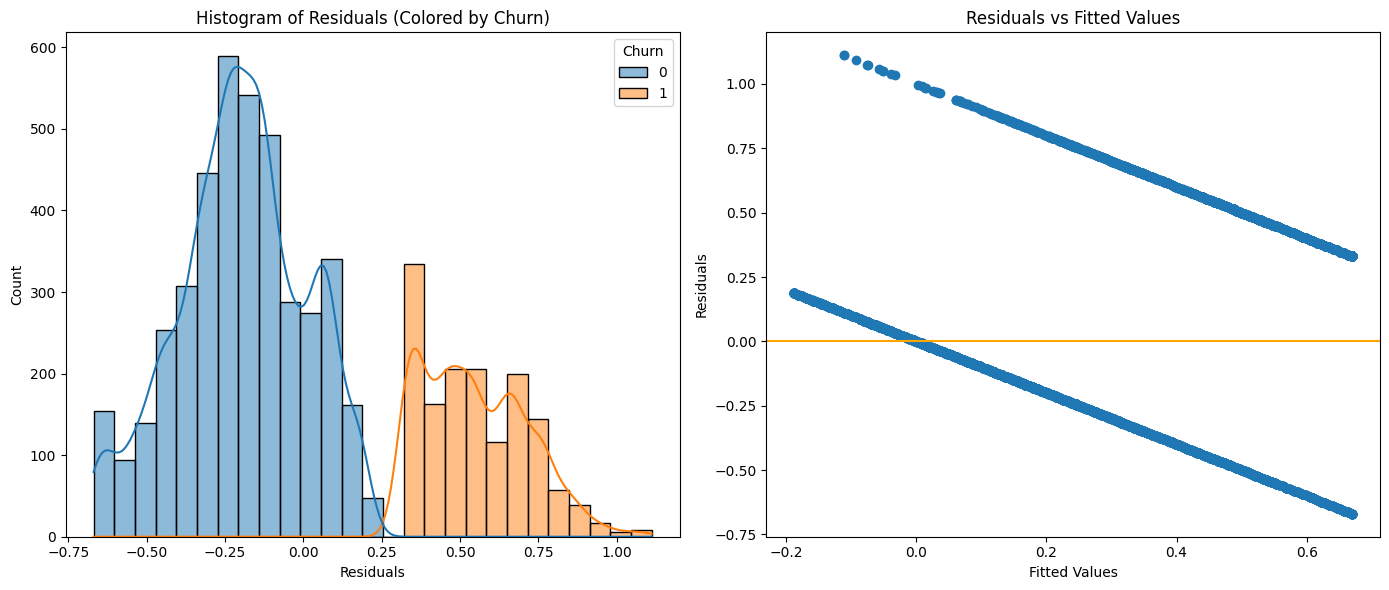

In [46]:
# look at residuals 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# make df w a column for residuals and another for churn
residuals = model.resid
data_for_hist = pd.DataFrame({'residuals': residuals, 'Churn': y_train})
sns.histplot(data=data_for_hist, x='residuals', hue='Churn', kde=True, ax=axes[0])
axes[0].set_xlabel("Residuals")
axes[0].set_title("Histogram of Residuals (Colored by Churn)")

# also, could plot residuals vs fitted values to check for relationships 
fitted_values = model.fittedvalues
axes[1].scatter(fitted_values, residuals)
axes[1].axhline(0, color='orange')
axes[1].set_xlabel("Fitted Values")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs Fitted Values")
plt.tight_layout()
plt.show()

Training a logistic regression model:

- The residual distribution above shows that the model might be underpredicting churners and overpredicting non-churners. The blue distribution in the hisotgram show that the model underpredicts for customers who did not churn and the orange distribution shows a wider spread and a shift towards positive residuals. 

- The next logical step is logsitic regression because it directly outputs a probability between 0 and 1. 

- ROC-AUC curves were utilized in the following classificatio models because the dataset is so imbalanced and accuracy is misleading in these cases.


In [47]:
# dict to store ROC curve data and confusion matrices for all models
roc_data_unsampled = {}
confusion_matrices = {}
Log_Reg = LogisticRegression(max_iter=1000, class_weight='balanced')
Log_Reg.fit(X_train, y_train)
y_pred = Log_Reg.predict(X_test) # predictions 
# eval performance
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# ROC-AUC curve
y_prob = Log_Reg.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_score}")
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_data_unsampled['Logistic Regression'] = (fpr, tpr, roc_score)
confusion_matrices['Logistic Regression'] = confusion_matrix(y_test, y_pred)

Confusion Matrix:
 [[736 297]
 [ 78 296]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.75      1407

ROC-AUC Score: 0.8291850225965596


2. **Tree-Based Models:**
   - Random Forest and  XGBoost were used to capture non-linear interactions better. XGBoost was included for its ability to handle imbalanced datasets well.





Random Forest



In [48]:
# X_train, X_test, y_train, y_test already defined
rf_model = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

# GridSearchCV to find best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
print(f"Best Parameters:", grid_search.best_params_)

# eval best model on test data
y_pred = best_rf_model.predict(X_test)
confusion_matrices['Random Forest'] = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:") 
print(classification_report(y_test, y_pred))

# ROC-AUC curve
y_prob = best_rf_model.predict_proba(X_test)[:, 1]  
roc_score = roc_auc_score(y_test, y_prob)         
print(f"ROC-AUC Score: {roc_score}")
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_data_unsampled['Random Forest'] = (fpr, tpr, roc_score)

# extract the 5 most important features
feature_importances = pd.DataFrame(best_rf_model.feature_importances_, index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)
print("Top Features:\n", feature_importances.head(5))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.7960

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.66      0.48      0.56       374

    accuracy                           0.80      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.80      0.78      1407

ROC-AUC Score: 0.8317164584746158
Top Features:
                                 Importance
tenure                            0.222289
RevenuePerMonth                   0.145703
MonthlyCharges                    0.126821
InternetService_Fiber_optic       0.091351
PaymentMethod_Electronic_check    0.061898


3. **Boosting Methods:**
   - XGBoost was included for its ability to handle imbalanced datasets well.




In [49]:
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
param_grid_xgb = {'n_estimators': [50, 100, 200],'max_depth': [3, 5, 7],'learning_rate': [0.01, 0.1, 0.2],
                  'subsample': [0.8, 1.0],'colsample_bytree': [0.8, 1.0]}

# tune hyperparams w GridSearchCV and obtain best model and params
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, n_jobs=-1, scoring='accuracy', verbose=1)
grid_search_xgb.fit(X_train, y_train)
best_xgb_model = grid_search_xgb.best_estimator_
print(f"Best Parameters for XGBoost:", grid_search_xgb.best_params_)

# eval on test data
y_pred_xgb = best_xgb_model.predict(X_test)
confusion_matrices['XGBoost'] = confusion_matrix(y_test, y_pred_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Test Accuracy: {accuracy_xgb:.4f}")
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# ROC-AUC curve
y_prob = best_xgb_model.predict_proba(X_test)[:, 1]  
roc_score = roc_auc_score(y_test, y_prob)    
print(f"ROC-AUC Score: {roc_score}")     
roc_data_unsampled['XGBoost'] = (fpr, tpr, roc_score)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
XGBoost Test Accuracy: 0.7875

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC-AUC Score: 0.8310680692236411


5. **Ensemble Model:**
   - A Voting Classifier was used to combine Random Forest, XGBoost, and Logistic Regression to combine the strengths of each model.




In [50]:
voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))  
], voting='soft', weights=[2, 3, 1]) # soft=probability weighted voting

voting_clf.fit(X_train, y_train)

# eval
y_pred_voting = voting_clf.predict(X_test)
confusion_matrices['Voting Classifier'] = confusion_matrix(y_test, y_pred_voting)
accuracy = accuracy_score(y_test, y_pred_voting)
print(f"VotingClassifier Accuracy: {accuracy:.3f}")
print("Classification Report:\n") 
print(classification_report(y_test, y_pred_voting))

# ROC-AUC curve
y_prob_vclf = voting_clf.predict_proba(X_test)[:, 1]  
roc_score = roc_auc_score(y_test, y_prob)         
print(f"ROC-AUC Score: {roc_score}")
fpr, tpr, thresholds = roc_curve(y_test, y_prob_vclf)
roc_data_unsampled['Voting Classifier'] = (fpr, tpr, roc_score)

VotingClassifier Accuracy: 0.800
Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.67      0.50      0.57       374

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407

ROC-AUC Score: 0.8310680692236411


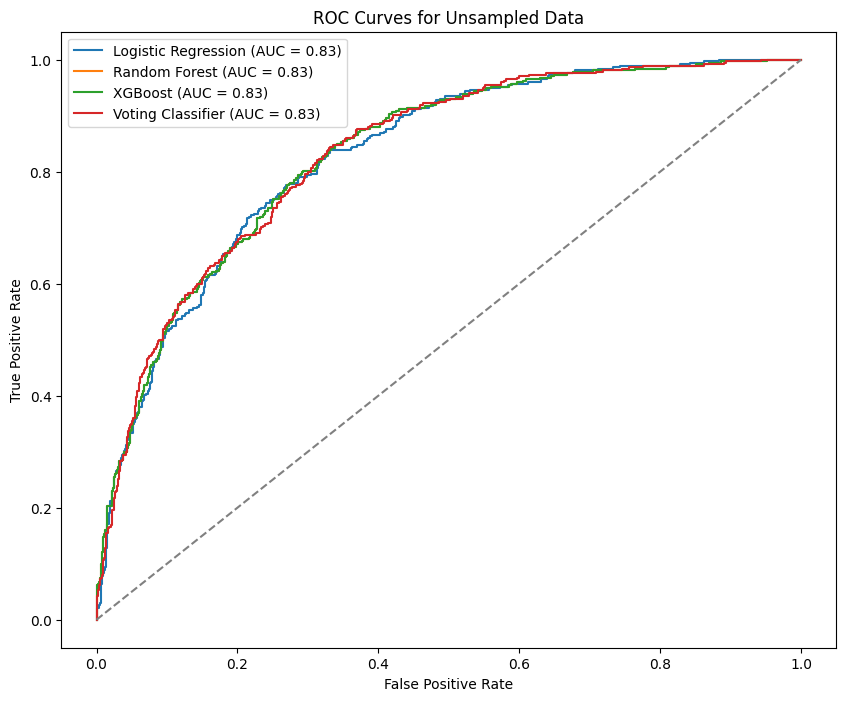

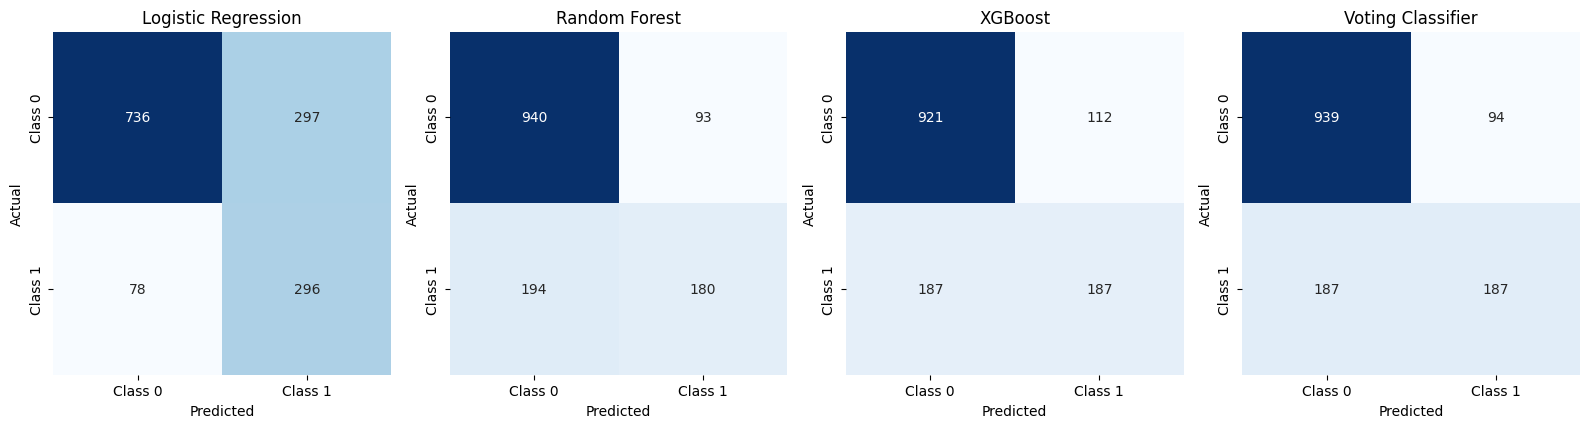

In [51]:
# plotting ROC Curves for unsampled data
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, roc_score) in roc_data_unsampled.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Unsampled Data')
plt.legend()
plt.show()

# plot each confusion matrix in 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16)) 
axes = axes.ravel()

for i, (model_name, conf_matrix) in enumerate(confusion_matrices.items()):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i],
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    axes[i].set_title(model_name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# turn off unused subplots
for j in range(len(confusion_matrices), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Resampling

- Resampling helps when delaing with imbalanced datasets. SMOTEENN is used here to combine Syntehtic Minority Oversampling Technique with Edited Nearest Neighbors. This will address oversampling and noise reduction simulataneously. 

In [52]:
from imblearn.combine import SMOTEENN
# SMOTEENN for resampling
sm = SMOTEENN()
X_res, y_res = sm.fit_resample(X, y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42) #split resampled data

# dict to store ROC curve data and confusion matrices for resampled data
roc_data_resampled = {}
confusion_matrices = {}

# logistic regression w resampled data
Log_Reg = LogisticRegression(max_iter=1000, class_weight='balanced')
Log_Reg.fit(Xr_train, yr_train)
yr_pred_lr = Log_Reg.predict(Xr_test)
confusion_matrices['Logistic Regression'] = confusion_matrix(yr_test, yr_pred_lr)

# eval
print("Classification Report Logistic regression w resampled data:\n")
print(classification_report(yr_test, yr_pred_lr))
yr_prob_lr = Log_Reg.predict_proba(Xr_test)[:, 1]
roc_score = roc_auc_score(yr_test, yr_prob_lr)
print(f"ROC-AUC Score: {roc_score}")
fpr, tpr, thresholds = roc_curve(yr_test, yr_prob_lr)
roc_data_resampled['Logistic Regression'] = (fpr, tpr, roc_score)

# random forest model w resampled data
rf = RandomForestClassifier(random_state=42)
rf.fit(Xr_train, yr_train)

# eval
yr_pred_rf = rf.predict(Xr_test)
confusion_matrices['Random Forest'] = confusion_matrix(yr_test, yr_pred_rf)
print("Accuracy Random forest model w resampled data:", accuracy_score(yr_test, yr_pred_rf))
print("\nClassification Report Random forest model w resampled data:", classification_report(yr_test, yr_pred_rf))
yr_prob_rf = rf.predict_proba(Xr_test)[:, 1]  
roc_score = roc_auc_score(yr_test, yr_prob_rf)         
print(f"ROC-AUC Score: {roc_score}")
fpr, tpr, thresholds = roc_curve(yr_test, yr_prob_rf)
roc_data_resampled['Random Forest'] = (fpr, tpr, roc_score)


# XGBoost w resampled data
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0)
xgb_model.fit(Xr_train, yr_train)
yr_pred_xgb = xgb_model.predict(Xr_test)
confusion_matrices['XGBoost'] = confusion_matrix(yr_test, yr_pred_xgb)

# eval
accuracy_xgb = accuracy_score(yr_test, yr_pred_xgb)
print(f"Test Accuracy XGBoost w resampled data: {accuracy_xgb:.4f}")
print("\nClassification Report XGBoost w resampled data:")
print(classification_report(yr_test, yr_pred_xgb))
yr_prob_xgb = rf.predict_proba(Xr_test)[:, 1]  
roc_score = roc_auc_score(yr_test, yr_prob_xgb)         
print(f"ROC-AUC Score: {roc_score}")
fpr, tpr, thresholds = roc_curve(yr_test, yr_prob_xgb)
roc_data_resampled['XGBoost'] = (fpr, tpr, roc_score)


# votingclassifier w resampled data
voting_clf = VotingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
                                          ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, eval_metric='logloss')),
                                          ('lr', LogisticRegression(max_iter=1000, random_state=42))], 
                                          voting='soft', weights=[2, 3, 1])  
voting_clf.fit(Xr_train, yr_train)

# eval
yr_pred_voting = voting_clf.predict(Xr_test)
confusion_matrices['Voting Classifier'] = confusion_matrix(yr_test, yr_pred_voting)
accuracy_voting = accuracy_score(yr_test, yr_pred_voting)
print(f"Accuracy votingclassifier w resampled data: {accuracy_voting:.3f}")
print("\nClassification Report votingclassifier w resampled data:")
print(classification_report(yr_test, yr_pred_voting))
yr_prob_vclf = voting_clf.predict_proba(Xr_test)[:, 1]  
roc_score = roc_auc_score(yr_test, yr_prob_vclf)         
print(f"ROC-AUC Score: {roc_score}")
fpr, tpr, thresholds = roc_curve(yr_test, yr_prob_vclf)
roc_data_resampled['Voting Classifier'] = (fpr, tpr, roc_score)

Classification Report Logistic regression w resampled data:

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       570
           1       0.93      0.90      0.91       724

    accuracy                           0.90      1294
   macro avg       0.90      0.90      0.90      1294
weighted avg       0.90      0.90      0.90      1294

ROC-AUC Score: 0.9638339633614423
Accuracy Random forest model w resampled data: 0.9366306027820711

Classification Report Random forest model w resampled data:               precision    recall  f1-score   support

           0       0.92      0.93      0.93       570
           1       0.95      0.94      0.94       724

    accuracy                           0.94      1294
   macro avg       0.94      0.94      0.94      1294
weighted avg       0.94      0.94      0.94      1294

ROC-AUC Score: 0.989554860909179
Test Accuracy XGBoost w resampled data: 0.9134

Classification Report XGBoost w resampled d

## Results and Analysis
### Summary:
The project focused on evaluating multiple machine learning models to predict customer churn. The primary challenges of the dataset were imbalanced class distribution and potential feature collinearity. I addressed these through advanced techniques like SMOTEENN for resampling and feature selection based on Variance Inflation Factor (VIF). The results are summarized below with supporting visualizations and evaluation metrics tailored to address the imbalanced nature of the data.
#### Performance on Original Data
- **Logistic Regression:** Accuracy of 73%, with a ROC-AUC of 0.83, but low precision (0.50) and recall (0.79) for the minority class highlight its limitations with imbalanced data.
- **Random Forest:** Accuracy improved to 80% and ROC-AUC reached 0.83, with better performance on precision for minority class (0.66) but still struggling with recall for minority class (0.48).
- **XGBoost:** Accuracy of 79% and ROC-AUC of 0.83, showing a balanced performance but not much better than Random Forest.
- **Voting Classifier (Ensemble):** Combined model strengths with 80% accuracy and a ROC-AUC of 0.83, providing slight performance improvement.
#### Performance on Resampled Data (SMOTEENN)
The use of resampled data significantly improved model performance by addressing class imbalance:
- **Logistic Regression:**  Accuracy of 91% and a ROC-AUC of 0.96, showing a ton of improvement, though non-linear models still performed better.
- **Random Forest:** Accuracy of 95%, with strong recall on minority class (0.98) and a ROC-AUC of 0.99, making it highly effective for identifying churn.
- **XGBoost:** Achieved 93% accuracy and a ROC-AUC of 0.99, excelling across metrics while maintaining model efficiency.
- **Voting Classifier (Ensemble):** Accuracy of 94% and ROC-AUC of 0.987, demonstrating strong performance by combining individual model strengths.

## Visualizations
1. **ROC Curves:** 
- ROC curves compare the models' ability to distinguish between churn and non-churn classes. ROC-AUC is a better metric than accuracy for imbalanced datasets because it measures the model's ability to distinguish between both positive and negative classes across different classification thresholds.
- On unsampled data, models achieved a ROC-AUC of 0.83, highlighting consistent performance across Logistic Regression, Random Forest, XGBoost, and Voting Classifier.
 - On resampled data, ROC-AUC increased to 0.99 for tree based models, showing substantial improvement.

2. **Confusion Matrices:** 
- Clearly visualize the trade offs between precision, recall, and accuracy across both sampled and unsampled datasets.
- Improvements in recall for the minority class were seen after resampling, especially for Random Forest.

3. **Evaluation Metrics:**

- Metrics included accuracy, precision, recall, F1-score, and ROC-AUC to provide a balanced evaluation of model performance.
- ROC-AUC and recall were prioritized to ensure the models effectively captured churners (minority class).


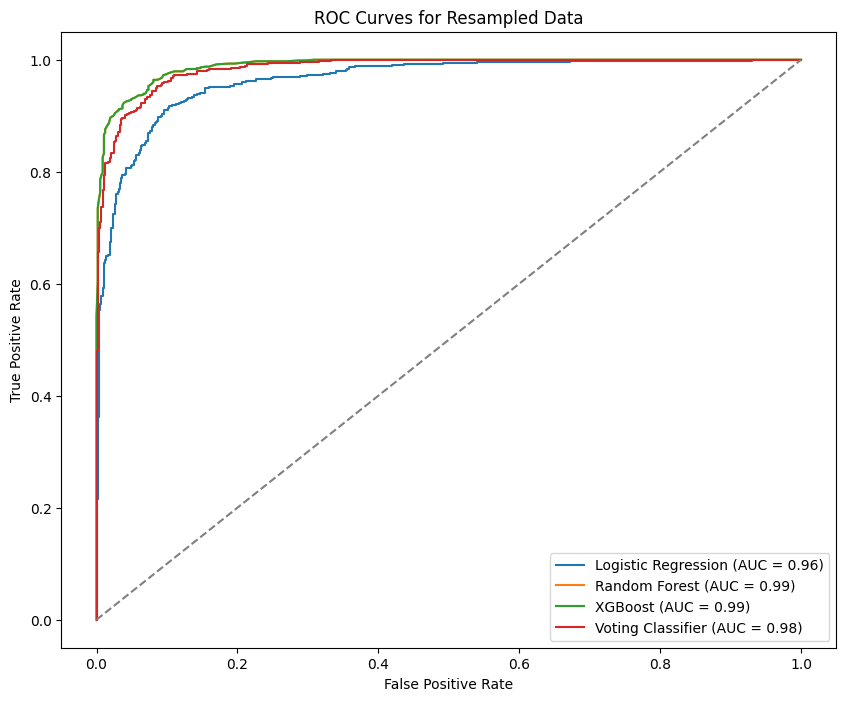

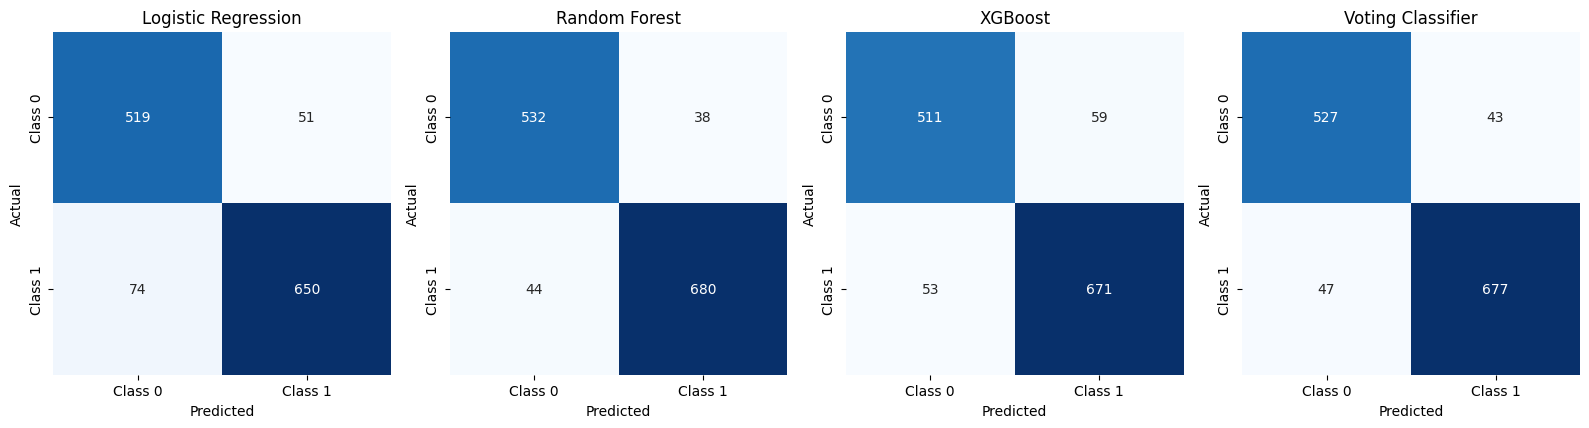

In [53]:
# plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, roc_score) in roc_data_resampled.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Resampled Data')
plt.legend()
plt.show()

# plot each confusion matrix as 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))  
axes = axes.ravel()

for i, (model_name, conf_matrix) in enumerate(confusion_matrices.items()):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i], xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    axes[i].set_title(model_name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# turn off unused subplots
for j in range(len(confusion_matrices), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Interpretation of Metrics

**ROC-AUC:** I chose this as the primary evaluation metric because of its ability to capture class separation well even in datasets with class imbalance.

**Recall:**  I focused on recall as well to make sure that the churners (minority class) were correctly identified, which is importnt for business impact.

**F1-score:** This metric provided me a balanced measure of precision and recall, which was especially useful for comparing models on resampled data.

## Iterative Improvements
**Addressing Data Imbalance:** Resampling with SMOTEENN significantly improved model performance, especially for Logistic Regression (accuracy from 73% to 91%) and Random Forest (accuracy from 80% to 95%).

**Feature Selection:** VIF analysis and correlation heatmaps were used to identify multicollinearity. Features like RevenuePerMonth were created from TotalCharges and tenure and redundant features like PhoneService and TotalCharges were dropped to simplify the models without sacrificing performance.

**Model Optimization:** Hyperparameter tuning with GridSearchCV was employed for all models to make sure I achieved optimal performance on the resampled dataset.

## Conclusions

### Key Findings
- **Random Forest** has the best performing model on the resampled data, achieving the highest ROC-AUC (0.99) and a recall of 0.97 for the minority class. It also had an accuracy of 96%, making it highly effective forpredicting churn.
- **XGBoost** closely followed behind with a ROC-AUC of 0.99 and good balance between precision and recall, showing strong generalization while also being efficient in handling imbalanced data.
- **Voting Classifier** combined the strengths of multiple models, achieving a ROC-AUC of 0.99 with robust performance across metrics with a recall of 0.96 and a F1-score of 0.96 for class 1. However, it did not significantly outperform Random Forest.
- **Logistic Regression** improved significantly on resampled data, with a ROC-AUC of 0.96 and a balanced precision and recall. However, it was less effective at capturing non-linear relationships compared to tree-based models.

### Recommendations
- Random Forest is recommended for production deployment due to the combination of high performance and efficient use of resampled data.
- Ensemble methods like Voting Classifier could be further optimized by including diverse models such as SVM's or adjusting the voting weights.
- For further improvements, one could experiment with more advanced resampling techniques like SMOTE-GAN.

### Takeaways
- The importance of taking care of class imbalance is clear, as seen by the resampling techniques significantly enhancing model performance.
- Tree-based models, demonstrated strong performance by handling non-linear relationships and imbalanced data.
- Ensembling models can provide robustness but may nned more diverse base models for significant improvements.

### Future Directions
- Investigate advanced ensembling techniques like stacking.
- Explore feature engineering to improve model interpretability and performance.
- Consider using SMOTE-GAN resampling techniques. 
- Apply these methods to larger, real-world datasets to validate findings.

